# Project1: Particle identification in Liquid Argon Time Projection Chambers

<img src="http://deeplearnphysics.org/DataChallenge/static/images/Entry078_data.png" alt="TPC3D" style="width: 400px;"/>

## Introduction

---

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">Data Scientist (n.): Person who is better at statistics than any software engineer and better at software engineering than any statistician.</p>&mdash; Josh Wills (@josh_wills) <a href="https://twitter.com/josh_wills/status/198093512149958656?ref_src=twsrc%5Etfw">May 3, 2012</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script> 

---
### Time Projection Chambers (TPC)
Liquid argon TPCs are a type of neutrino detector which aims at providing high-resolution 3D track reconstruction which can in principle provide unprecedented detail in neutrino event reconstruction.

Charged particles in liquid argon produce ionization electrons, which drift to the readout wire planes in an electric field of 273 V/cm. It takes 2.3 ms for an ionization electron to drift across the full width of the detector.
One such LArTPC detector is found in the MicroBooNE experiment. MicroBoone has been recording data since 2015, and continuously records charge drifted and its arrival time on each wire. 
As a charged particle passes through a medium, it will create ionisation. In a TPC, an electric field causes the produced electrons to drift to anode wires at the end of the vessel. The drift time and the position of the hit wire are combined to provide a 3D reconstruction of the event.

Wire and time data can be converted into an image format (charge on each wire versus drift time) while maintaining high resolution in wire, time and charge amplitude space. These information-rich
LArTPC images are suitable for applying deep learning tools.


### Example of first images from MicroBooNE experiment
Liquid argon TPCs are ideal for neutrino experiments because they provide a relatively large target mass (unlike gas TPCs, which by their nature have relatively low densities). Neutrino interactions with LAr nuclei can result in several distinc signatures, such as a proton (p) and electron (e) being produced at a vertex point ([images from 2010.08653 [hep-ex]](https://inspirehep.net/literature/1823841)):

<img src="https://inspirehep.net/files/cba430719ebf8bcb922cda5f98cb9824" alt="MicroBooNE" style="width: 300px;"/> 

a proton, electron and photon (y) being produced from a vertex point. The photon flies through the material undetected and converts to a electron and positron pair ([pair production](https://en.wikipedia.org/wiki/Pair_production)) creating an electromagnetic shower.

<img src="https://inspirehep.net/files/619950f112f0d77089e97134025c6d4e" alt="MicroBooNE" style="width: 300px;"/> 

a proton and muon:

<img src="https://inspirehep.net/files/9fe207573f051203a98987930e7a56c1" alt="MicroBooNE" style="width: 300px;"/> 

and many other topologies. Classification of particles within the detector volume is therefore vital to being able to detect and measure neutrino collisions. You can read up on how MicroBooNE designed a convolutional neural network to identify images at [2010.08653 [hep-ex]](https://inspirehep.net/literature/1823841), which may serve as inpiration for your own CNNs.

## TPC DATASET
We will be using the open dataset from [deeplearningphysics.org](http://deeplearnphysics.org/DataChallenge/), which consists of liquid argon time projection chamber (LArTPC) simulated data. There are some great resources in terms of [Tutorials](http://deeplearnphysics.org/Blog/tutorial_summary.html#tutorial_summary) which describe the data, though the code that is used there is not applicable here directly.

The subset of the dataset used are 90K in total simulated events for the purpouse of particle classification. Unlike the images we see above, the events here only have one particle in them, for the purpouse of doing particle by particle classification.

Each event contains 3 projected images on the XY, YZ, and ZX planes.
Each 2D image spans 128cm x 128cm space with 256 x 256 pixels, meaning each pixel corresponds to 0.5 cm in vertical and horizontal size. 

### Example 
Three 2D projected images from an event of a simulated electron. Blue colors are lower pixel intensity, meaning little to no ionisation capture, while red pixels are hot, meaning high ionisation. The point where the true particle is produced is marked with an X is taken from the truth information.

![panes](https://cernbox.cern.ch/index.php/s/ulFmgU3nAjw9X8i/download)

In [2]:
# Standard import(s)
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
print(tf.__version__)

2.7.0


In [4]:
# Keras import(s)
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.models import Model, Sequential, load_model, save_model
from tensorflow.python.keras.layers import Input, Dense, Dropout, Flatten, Reshape, Conv2D,RepeatVector, Conv2DTranspose, MaxPooling2D, Concatenate, Lambda,BatchNormalization, UpSampling2D
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.losses import binary_crossentropy
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.backend import set_image_data_format
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
set_image_data_format('channels_last')  # Images are formatted as (N, N, 1), with colour-channels last
import scipy.sparse as sparse



---
### The image dataset

You can download the datasets from [this folder](https://cernbox.cern.ch/index.php/s/qk8uZgYlg7VubRi). You need both `LArTPC_images_90k.npz` and `LArTPC_truth_90k.npy`

In [5]:
images = sparse.load_npz("LArTPC_images_90k.npz")
print(type(images),images.shape,np.prod(images.shape))

<class 'scipy.sparse.csr.csr_matrix'> (90000, 196608) 514850816


**Note on image data**

The data has been pre-prepared and loaded as **sparse matrices**. We use this special format since each image has `(256x256x3)= ` 197 thousand pixels. Loading the entire 90'000 images in a **dense matrix** (every value filled) to RAM would be **17 billion pixels and over 30GB** of nessesary RAM!

However, since we have lots and lots of 0s in the images, which are largely empty except for pixels with particle activity, we can ignore the 0s with a sparce representation of the data, by keeping track of the index of the active pixels.


In [6]:
images

<90000x196608 sparse matrix of type '<class 'numpy.float64'>'
	with 66286812 stored elements in Compressed Sparse Row format>

With our sparse representation we only load **66 million active pixels** and their indexes (positions), which only take up around **500 MB**! 

Notice that our data images are flattened to 196608 pixels from the original (256,256,3). This is because sparce matrices only support two dimensional matrices. To get back our original image we need to reshape the image back.

Here is a function to retrive the original 3 images in the XY, YZ and ZX planes

**IMPORTANT:** Converting the images this way requires conversion to dense matrix, meaning the zeros are reintreduced. Hece we should only do this on a few events! 

In [7]:
def toimage(sparsearray):
    #Convert to dense array, and reshape to three 2D images
    reshape = sparsearray.toarray().reshape((256,256,3))
    return reshape[:,:,0], reshape[:,:,1], reshape[:,:,2]

Lets grab the 1st particle and retrieve the images using the `jet` color map.



In [8]:
XY,YZ,ZX = toimage(images[0])

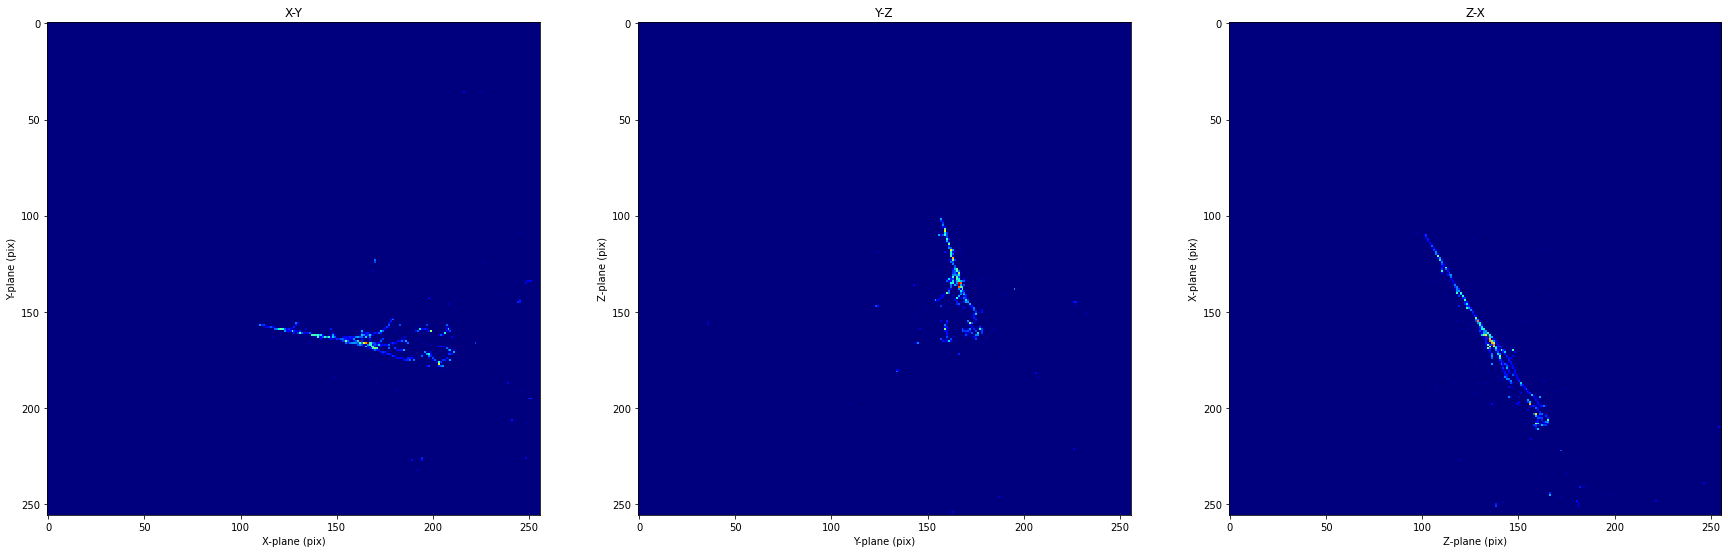

In [9]:
labels=["X-Y","Y-Z","Z-X"]
ilist= toimage(images[0])
fig = plt.figure(figsize=(30,10))

for index, image in enumerate(ilist):

    plt.subplot(1,3,index+1)
    #Show the image with imshow:
    plt.imshow(image, interpolation='none',cmap='jet')
    plt.xlabel('{}-plane (pix)'.format(labels[index].split("-")[0]))
    plt.ylabel('{}-plane (pix)'.format(labels[index].split("-")[1]))
    plt.title(labels[index])
fig.savefig("lar_planes.png")

---
### Truth information

Real data in a neutrino experiment does not come with labels, but since our dataset is simulated, we have the **truth level information** of the particles. We load the truth dataset here.

In [10]:
truth = np.load("LArTPC_truth_90k.npy")

We have eight truth arrays present in the dataset

- The particle ID (particle type ID as defined by the [particle data group](https://pdg.lbl.gov/2007/reviews/montecarlorpp.pdf))
    - 11   : 'electron',
    - 22   : 'photon',
    - 13   : 'muon',
    - 211  : 'pion',
    - 2212 : 'proton'
- The total momentum (p) of the initial particle in MeV
- The x component (px) of momentum in MEV
- The y component (py) of momentum in MEV
- The x component (pz) of momentum in MEV
- The x position of the production of the particle in cm
- The y position of the production of the particle in cm
- The z position of the production of the particle in cm


In [11]:
p_id , p_ptot, p_px, p_py, p_pz, p_x, p_y, p_z= (truth[:,i] for i in range(truth.shape[1]))

In [12]:
truth.shape

(90000, 8)

# Project

For the project are required to perform an in depth investigation of the image dataset, and design **two** machine learning techniques from the dataset. The first tasks are **compulsary** where you are required explore the data and create an algorithm to identify/classify the particle in each event.  

## Task 0: Data exploration
* Explore a few images from each particle type, trying to identify how the particles are different between categories. Explore how the images change with different initial momenta. Remember that each event has three 2D images which should be veiwed simultaneously to get the full picture.
* Explore the truth information to get an idea of the dataset composition.

## Task 1: Image classification
* Create an algorithm to identify each event as being from one of five types of particles present in the datase
* You are strongly encouraged to use a convolutional neural network (CNN) classifier on the images, though this is not compulsary.
* Explore different architectures for the model, and explain in detail your choice of model, and the final parameters chosen. Consider doing a robust hyperparameter search.
* Explore the results and documents your findings. Ask as many questions about your model as you can, and document your findings.
    * Which particles are easy to identify, and which are not? 
    * What are the physics reasons for why some particles are similar?
    * Is there a dependence on particle position or momentum in your classifier for certain particle types?
    * Can you come up with a selection which gives good paricle purity?

## Task 2: Choose from one (or several) of these
Pick an additional task from this set, or come up with your own study that is not listed here. You should follow a similar approach as to **Task 1** above, but without as much detail needed. Consider *Task0 and Task 1* to be with 70% and *Task 2* to be worth the remaining *30%*.

* Create a regression algorithm which predicts the particle momentum for electrons, either the total momentum, or the px, py and pz. Determine the quality of the regression trained on electrons on photons. Explain the performace.
* Create a regression algorithm which predicts the x, y and z position of protons
* Create an autoencoder (AE) to reduce noise in the detector images. Do injection tests of random noise with different intensities to check your results. Some code to generate noise can be found in the [Keras AE tutorial](https://blog.keras.io/building-autoencoders-in-keras.html)
* Create a variable autoencoder (VAE) on the images for image generation of a paricular type. Try and make it conditional on momentum and position.
* _Etc._

To complete this project, you should:
* Perform **Task 0 and 1** and an additional task from **Task 2** (but not necessarily restricted to just these), label/number your studies, discuss the results, and compare their relative merits.
    * If you do any neat studies that don't result in a classification variable, _e.g._ image generation, that still very much counts!
* **Submit your Jupyter notebook** as a "report." See the comments below on documentation,
    
When doing each of your studies, you should try to follow the below steps (where it makes sense; rough weight in marking indicated in parentheses):

1. **Data exploration and preprocessing (10%):** Inspect the datasets; visualise the data in an appropriate way; study the composition of the dataset; perform any necessary preprocessing.
2. **Model selection (30%):** Choose a promising approach; construct the machine learning model; optimise the relevant hyperparameters; train your chosen model.
3. **Performance evaluation (20%):** Evaluate the model in a way that gauges its ability to generalise to unseen data; compare to other approaches; identify the best approach. 
4. **Discussion, style throughout (40%):** Discuss the reasoning or intuition behind your choices; the results you obtain through your studies; the relative merits of the methods you have developed, _etc._ Similarly, make sure that you write efficient code, document your work, clearly convey your results, and convince us that you have mastered the material.


That is, **you should submit, by Friday 3rd December 2020 at 4pm:**
* your report notebook via Turnitin.
    

For all task we're not looking for exceptional performace and high scores (although those are nice too), **we're mostly concerned with _best practices:_** If you are careful and deliberate in your work, and show us that you can use the tools introduced in the course so far, we're happy!

Training all of these models in sequence takes a very long time so **don't spend hours on training hundreds of epochs.** Be conservative on epoch numbers (30 is more than enough) and use appropiate techniques like EarlyStopping to speed things up.



### Documentation

Your reportnotebook should run without errors and give (mostly) reproducible results. It is important that **all** code is annotated and that you provide brief commentary **at each step** to explain your approach. Explain *why* you chose a given approach and *discuss* the results. You can also include any failed approaches if you provide reasonable explanation; we care more about you making an effort and showing that you understand the core concepts.

This is not in the form of a written report so do not provide pages of background material, but do try to clearly present your work so that the markers can easily follow your reasoning and can reproduce each of the steps through your analysis. Aim to convince us that you have understood the material covered in the course.

To add commentary above (or below) a code snippet create a new cell and add your text in "Markdown" format. Do not add any substantial commentary as a code comment in the same cell as the code. To change the new cell into markdown select from the drop down menu on the bar above the main window (the default is code)

---
# Lets get started

We need to define a few more things as we get started, but lets first split the data into 50K for training, and 40K reserved for testing

In [13]:
from sklearn.model_selection import train_test_split 

In [14]:
x_train, x_test, truth_train, truth_test = train_test_split(images,truth,train_size=50000,random_state=11)

In [15]:
toimage(x_train[0])[0].shape

(256, 256)

## Special notes for traning on sparse matrices

Since we are using sparce matrices instead of dense ones, we need to tweak the way we **train**, **evaluate**, and **predict** from our model. This is because each of these steps requires the data to be **dense**, and we will run into the previous mentioned memory issues very quickly.


The solution for this is by using a **data generator** which will only load the dense data in batches. I give the function below.

The `nn_batch_generator` takes in the input data `X_data`, labels `y_data` and `batch_size` and creates a mini dense batch based on the `batch_size`. The `yield` keyword is a type of `return` function but which allows the method to keep running. Since we usually train on small batches (e.g. `32` events per batch) the data should be able to fit in memory.

In [16]:
def nn_batch_generator(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y_data)[0])
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:].todense()
        y_batch = y_data[index_batch]
        counter += 1
        yield np.array(X_batch),y_batch
        if (counter > number_of_batches):
            counter=0


Below is an example of passing the generator itself into the fit method. Because the generator would run forever, we need to use the `steps_per_epoch` parameter to tell the training when to stop (i.e, it reached the end of the data). We therefore set `steps_per_epoch` to the number of training entries divided by the batch size. In this case I set 5000 entries aside for the validation set.

**Note these are just examples taken from my own notebooks so don't expect to just work out the box for you**
```
validation_slice=5000
batch_size=32
history_cnn = cnn.fit(nn_batch_generator(x_train[:-validation_slice],y_labels[:-validation_slice],batch_size=batch_size),
                      epochs=20,
                      steps_per_epoch=int((50000-validation_slice)/batch_size),
                      validation_data=(x_train[-valdation_slice:], y_labels[-validation_slice:]))

```


Similarly predict and evaluate methods take generators with the `steps` parameter to end the evalutation

```
cnn.predict(nn_batch_generator(x_train[-5000:], y_train_labels[-5000:],batch_size=50),steps=5000/50)
```

```
cnn.evaluate(nn_batch_generator(x_test, y_train_labels,batch_size=50),steps=len(cc)/50)
```



### Finally a note on training 
We are training on a huge amount of data in practice, so expect the training to be **very very slow!!!**. I was clocking a single CNN training with 30 epochs at around 90 minutes on my CPU. I would recommend trying to run hyperparemer tests at night while you are sleeping, or alternatively if you must run from the CP labs, run them on a smaller set of 5K samples, with 500 validation. However, note that although the smaller trainings may allow you to explore different parameters more quickly, it won't nessesarily translate to the big dataset as easily, so at some point you will want to launch some big trainings on networks you find promissing. Remember to document your process as much as possible!

It is absolutely **essential** that you use callbacks to reduce the training time
* Use ReduceLROnPlateau if the training has not improved after a number of epochs
* Use EarlyStopping to exit the training if it has not improved after a number of epochs (should be a larger number than what is used on ReduceLROnPlateau)
* Use ModelCheckpoint to save the *best* model to a unique file. You can then use keras `load_model` (already imported for you) to load the saved model and not have to retrain if you close the notebook. Alternatively you can save any model with `save_model`.

In [17]:
from tensorflow.python.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau



**If the project description is unclear, or if you experience any technical issues, please do let me know as quickly as possible. I can send around clarifications if I think it would be to the benefit of the entire class.**

---

**Your code below**

---

## TASK 0: Exploring the data set
* Explore a few images from each particle type, trying to identify how the particles are different between categories. Explore how the images change with different initial momenta. Remember that each event has three 2D images which should be veiwed simultaneously to get the full picture.
* Explore the truth information to get an idea of the dataset composition.

In [18]:
p_id, p_ptot, p_px, p_py, p_pz, p_x, p_y, p_z = (truth[:,i] for i in range(truth.shape[1]))

#### To first explore the BooNE dataset, I first print out images from each dataset. The following code prints out the first three images of each particle type.

In [19]:
#get the groups of images with particle names
#electrons are where the id is 11.0, photons are where the id is 22.0 etc
electrons = images[np.where(p_id == 11.0)]
photons = images[np.where(p_id == 22.0)]
muons = images[np.where(p_id == 13.0)]
pions = images[np.where(p_id == 211.0)]
protons = images[np.where(p_id == 2212.0)]

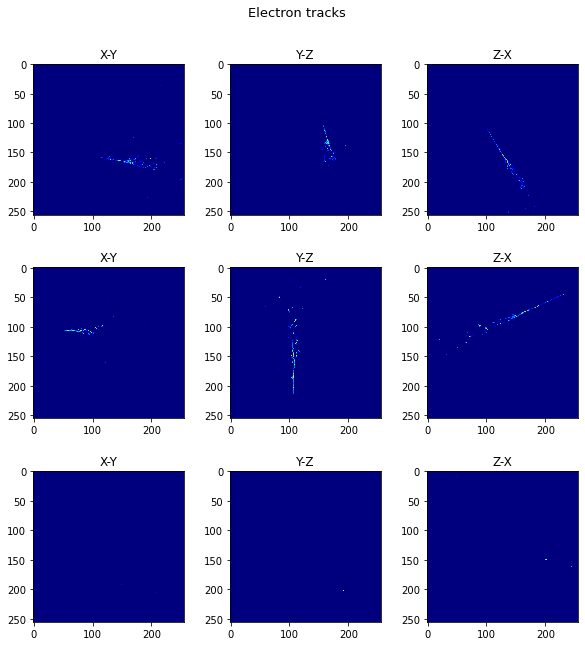

In [20]:
#plot three images of electrons, of three columns each, these are the xy, yz, and zx planes
figs, axs = plt.subplots(3, 3, figsize=(10,10))
for i in range(3):
    #converting image array of numbers into an actual image
    ilist= toimage(electrons[i])
    #get title and planes for each column
    for index, image in enumerate(ilist):
        axs[i,index].imshow(image, interpolation='none',cmap='jet')
        title = labels[index]
        axs[i,index].set_title(title)
plt.subplots_adjust(wspace=0.2, hspace=0.35)
figs.subplots_adjust(top=0.9)
plt.suptitle("Electron tracks",size=(13))
plt.show()

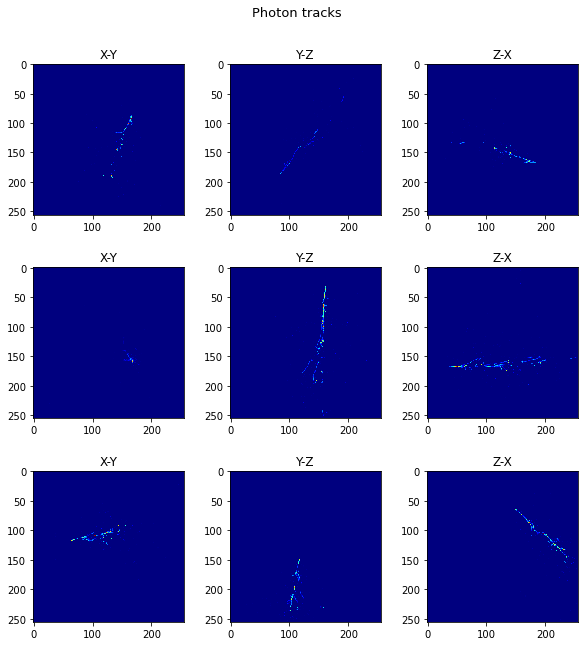

In [21]:
#plot images of first three photon tracks
figs, axs = plt.subplots(3, 3, figsize=(10,10))
for i in range(3):
    ilist= toimage(photons[i])
    for index, image in enumerate(ilist):
        axs[i,index].imshow(image, interpolation='none',cmap='jet')
        title = labels[index]
        axs[i,index].set_title(title)
plt.subplots_adjust(wspace=0.2, hspace=0.35)
figs.subplots_adjust(top=0.9)
plt.suptitle("Photon tracks",size=(13))
plt.show()

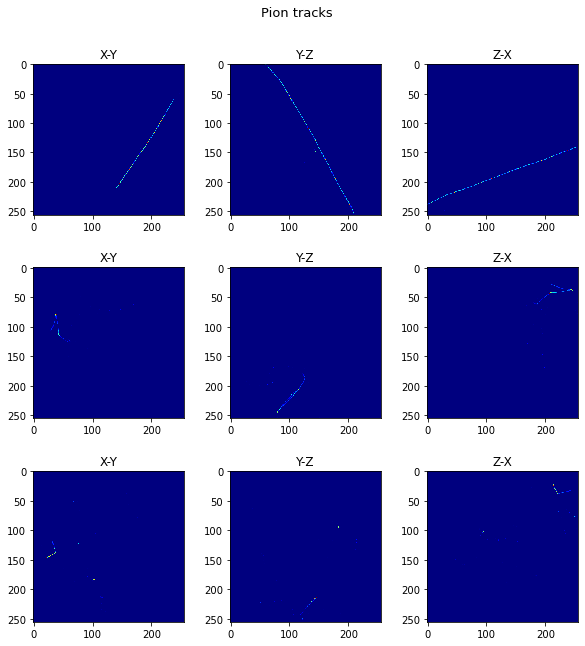

In [22]:
#plot images of first three pion tracks
figs, axs = plt.subplots(3, 3, figsize=(10,10))
for i in range(3):
    ilist= toimage(pions[i])
    for index, image in enumerate(ilist):
        axs[i,index].imshow(image, interpolation='none',cmap='jet')
        title = labels[index]
        axs[i,index].set_title(title)
plt.subplots_adjust(wspace=0.2, hspace=0.35)
figs.subplots_adjust(top=0.9)
plt.suptitle("Pion tracks",size=(13))
plt.show()

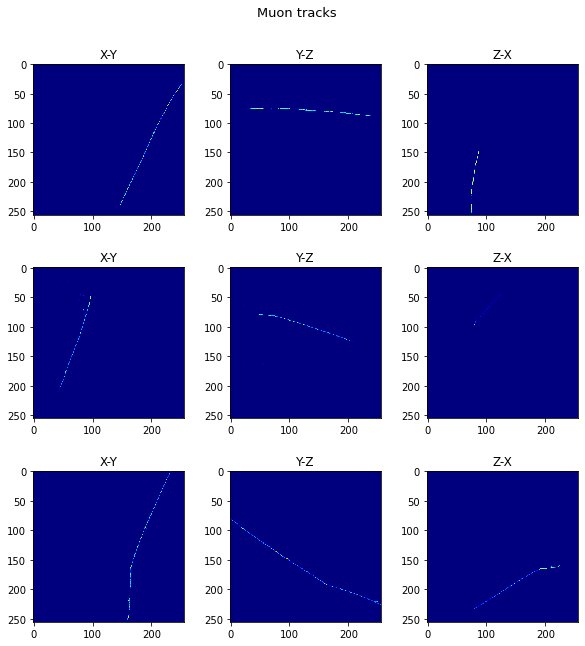

In [23]:
#plot images of first three muon tracks
figs, axs = plt.subplots(3, 3, figsize=(10,10))
for i in range(3):
    ilist= toimage(muons[i])
    for index, image in enumerate(ilist):
        axs[i,index].imshow(image, interpolation='none',cmap='jet')
        title = labels[index]
        axs[i,index].set_title(title)
plt.subplots_adjust(wspace=0.2, hspace=0.35)
figs.subplots_adjust(top=0.9)
plt.suptitle("Muon tracks",size=(13))
plt.show()

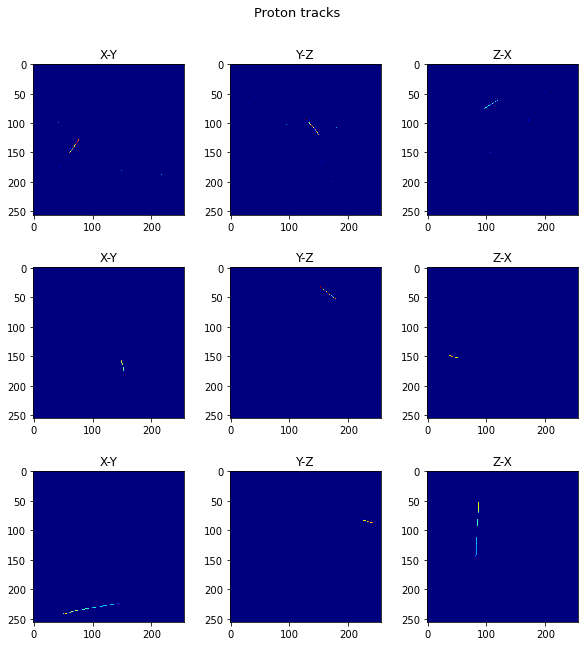

In [329]:
#plot images of first three proton tracks
figs, axs = plt.subplots(3, 3, figsize=(10,10))
for i in range(3):
    ilist= toimage(protons[200+i])
    for index, image in enumerate(ilist):
        axs[i,index].imshow(image, interpolation='none',cmap='jet')
        title = labels[index]
        axs[i,index].set_title(title)
plt.subplots_adjust(wspace=0.2, hspace=0.35)
figs.subplots_adjust(top=0.9)
plt.suptitle("Proton tracks",size=(13))
plt.show()

#### Here, I get seperate the truth data into arrays for each particle type:

In [21]:
#get the truth arrays for each particle type by indexing where particle id is equal to the particular particle type
electron_data = truth[np.where(p_id == 11.0)]
photon_data= truth[np.where(p_id == 22.0)]
muon_data = truth[np.where(p_id == 13.0)]
pion_data = truth[np.where(p_id == 211.0)]
proton_data = truth[np.where(p_id == 2212.0)]

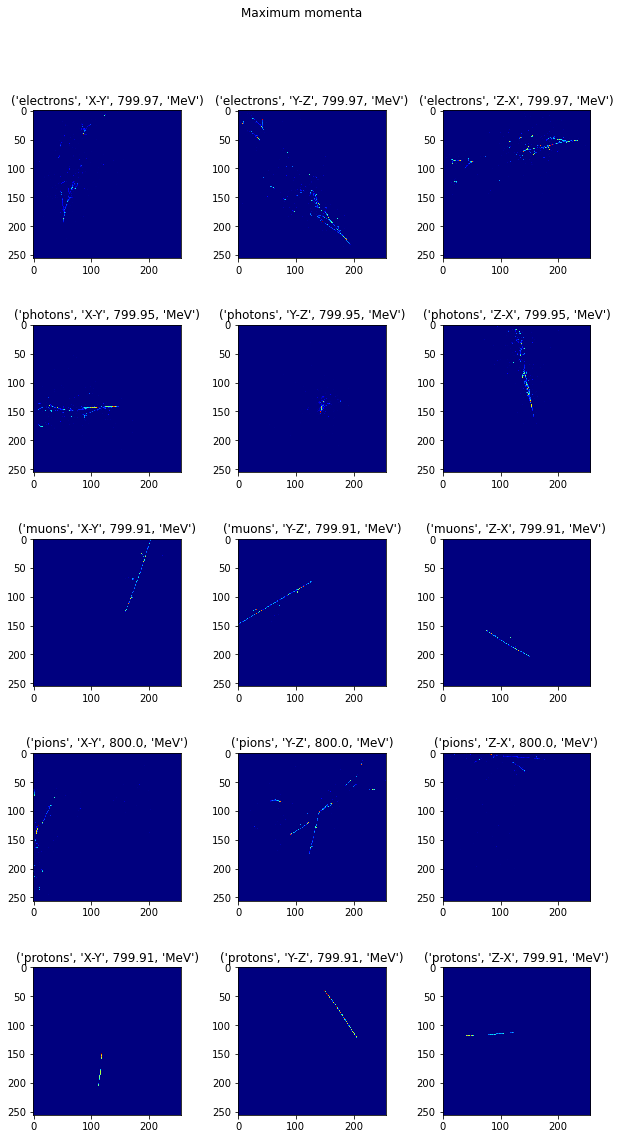

In [341]:
#plotting the maximum momentum for each particle for direct comparison
figs, axs = plt.subplots(5, 3, figsize=(11,18))
images_first=[electrons[np.argmax(electron_data[:,1])],photons[np.argmax(photon_data[:,1])],muons[np.argmax(muon_data[:,1])],pions[np.argmax(pion_data[:,1])],protons[np.argmax(proton_data[:,1])]]
#get particle labels so we can identify what the figure is showing
particle_labels = ['electrons','photons','muons','pions','protons']
#get particle maximum momenta as an array
momenta = [max(electron_data[:,1]),max(photon_data[:,1]),max(muon_data[:,1]),max(pion_data[:,1]),max(proton_data[:,1])]
for i in range(5):
    for j in range(5):
        ilist= toimage(images_first[i])
        for index, image in enumerate(ilist):
            axs[i,index].imshow(image, interpolation='none',cmap='jet')
            #title the graphs the particle, the plane, and the momentum
            title = particle_labels[i],labels[index],round(momenta[i],2),str('MeV')
            axs[i,index].set_title(title)
figs.subplots_adjust(wspace=0, hspace=0.45)
figs.subplots_adjust(top=0.9)
figs.suptitle('Maximum momenta')
plt.show()

#### The most noticeable features we see here is that photon and electron tracks are very similar, both have relatively long tracks with lots of sprays, and they both cover roughly the same amount of the image. The only difference between them being that photons appear to be slightly ionizing, you can see here the red pixels where the track is more intense. Muon pions and protons all have straight tracks with minimum sprays. Muon have the longest tracks, consisting of just one long line, whereas pions can consist of two to three sections of lines, depending on their energy. Protons have the shortest tracks and consist of red pixels - they are ionizing. You can see that at maximum momenta, photons are more ionizing than electrons, which may give a pattern to the CNN that it can regocnise, but overall the tracks between photons and electrons are very similar. At maximum momenta, muons and pions are less similar as pions tracks become less concise. It may be at low energies where the CNN is not successful at distinguishing between muons and pions.

#### Here I create a pandas dataframe in order to analyse the truth data set, ie the momentum and position of each particle.

In [23]:
import pandas as pd

In [24]:
#making a dataframe full of the momentum and position data
df = pd.DataFrame(data=truth, columns=['particle', 'ptot', 'px', 'py', 'pz', 'x', 'y', 'z'])

In [25]:
#the .groupby function shows that there are 18,000 simulations of each particle
df.groupby('particle').count()

,ptot,px,py,pz,x,y,z
particle,,,,,,,
11.0,18000,18000,18000,18000,18000,18000,18000
13.0,18000,18000,18000,18000,18000,18000,18000
22.0,18000,18000,18000,18000,18000,18000,18000
211.0,18000,18000,18000,18000,18000,18000,18000
2212.0,18000,18000,18000,18000,18000,18000,18000


In [26]:
#create a function that generates the images in the three planes
def generate_img(image,title):
    labels=["X-Y","Y-Z","Z-X"]
    ilist= toimage(image)
    fig = plt.figure(figsize=(15,5))

    for index, img in enumerate(ilist):

        plt.subplot(1,3,index+1)
        #Show the image with imshow:
        plt.imshow(img, interpolation='none',cmap='jet')
        plt.xlabel('{}-plane (pix)'.format(labels[index].split("-")[0]))
        plt.ylabel('{}-plane (pix)'.format(labels[index].split("-")[1]))
        plt.title(labels[index])
    plt.suptitle(title,size=(13))
    return plt.show()

#### Here, I want to analyse the images for lowest and highest momenta. This enables us to see the differences in low and high momentum for different particles and the characteristic particle tracks. The total momenta is given as the second column of the data frame, and so it is indexed as particle_data[:,1] - all rows for the first column. 

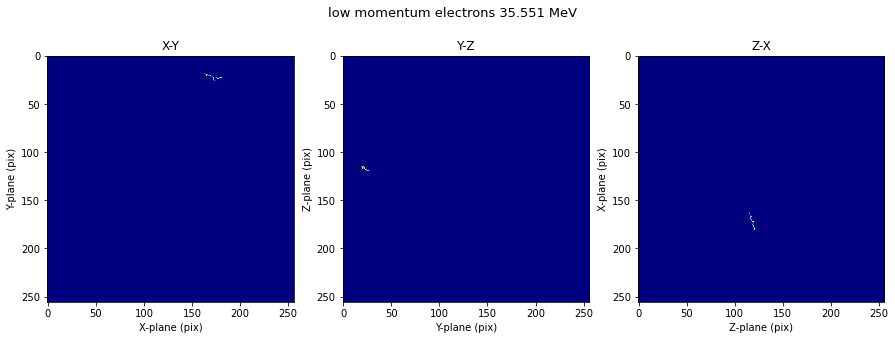

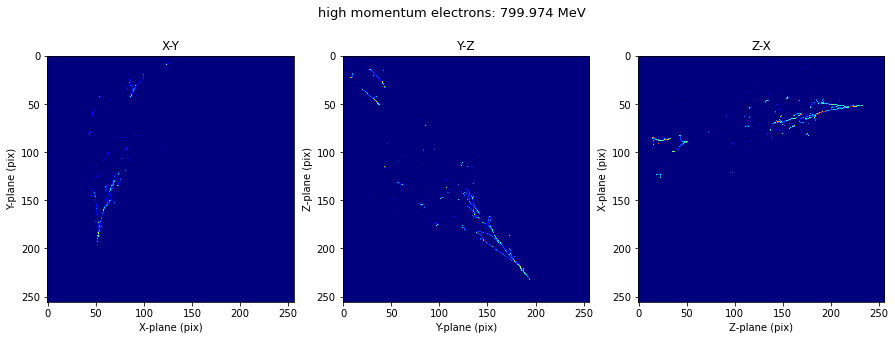

In [27]:
#minimum momentum
f = min(electron_data[:,1])
generate_img(electrons[np.argmin(electron_data[:,1])],'low momentum electrons %1.3f MeV'%f)
#maximum momentum
f = max(electron_data[:,1])
generate_img(electrons[np.argmax(electron_data[:,1])],'high momentum electrons: %1.3f MeV'%f)

#### Low momenta electrons, around 35MeV, have short tracks just a few pixels long. High momenta electrons, around 800MeV, have long sprays as tracks - they cover the width of the image, which is 256 pixels, and have many lines coming off the initial impact in all three planes.

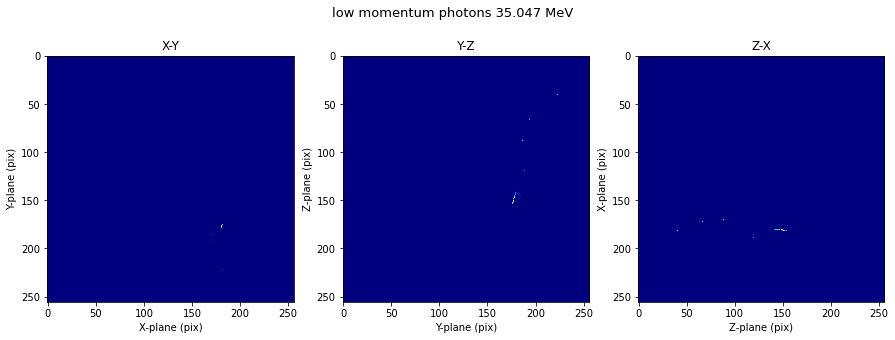

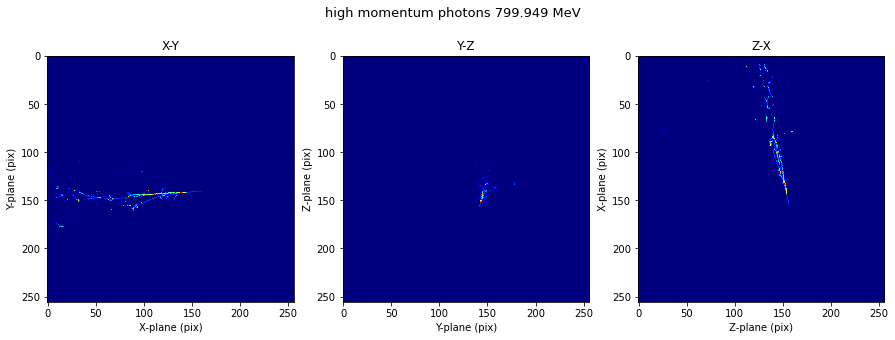

In [34]:
#minimum photon momentum
f = min(photon_data[:,1])
generate_img(photons[np.argmin(photon_data[:,1])],'low momentum photons %1.3f MeV'%f)
#maximum photon momentum
f = max(photon_data[:,1])
generate_img(photons[np.argmax(photon_data[:,1])],'high momentum photons %1.3f MeV'%f)

#### Low momenta photons, 35MeV have small sprays, the have one or two pixels off set from the main track which itself is as short as the electron and muon tracks. High momentum photos around 800MeV have sprays, very similar to electrons, but slightly less wide. Here, they only take up around half the width in the XY and ZX planes, and have a very small track in YZ, showing that the impact was in the YZ plane.

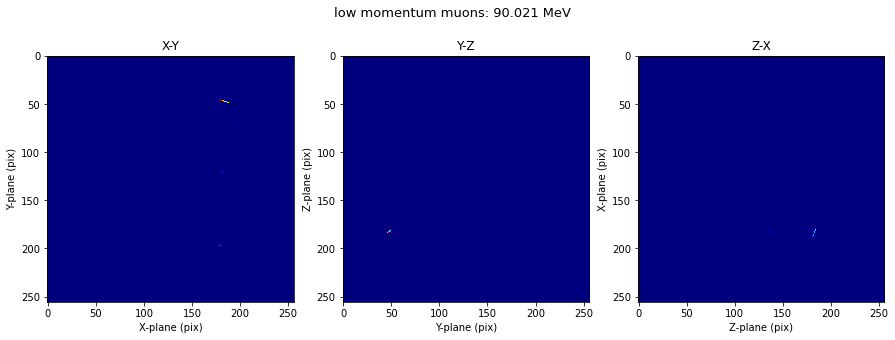

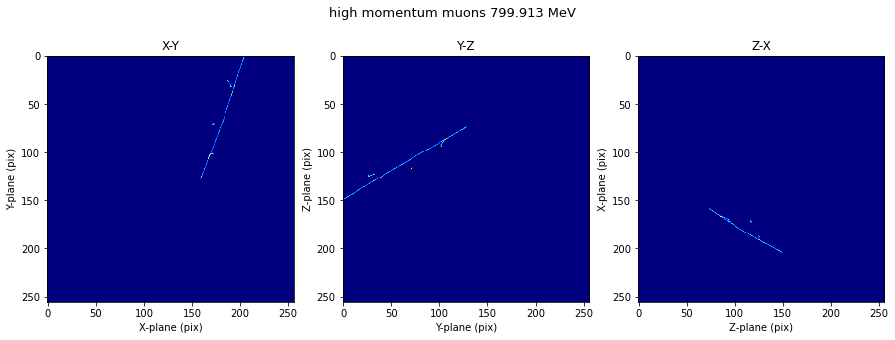

In [33]:
#minimum muon momentum
f = min(muon_data[:,1])
generate_img(muons[np.argmin(muon_data[:,1])],'low momentum muons: %1.3f MeV'%f)
#maximum muon momentum
f = max(muon_data[:,1])
generate_img(muons[np.argmax(muon_data[:,1])],'high momentum muons %1.3f MeV'%f)

#### Muons, at their lowest momenta, around 90MeV, have similar tracks to that of electrons at their lowest momenta, but even shorter. Almost 1 or 2 pixels. High momenta muons have straight, thin tracks, with no jets or sprays.

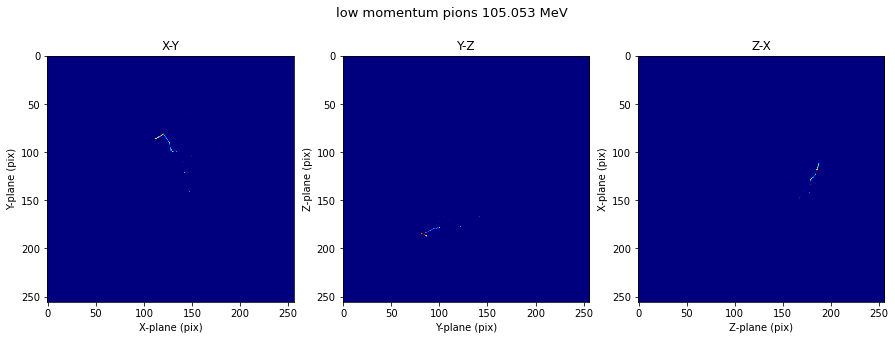

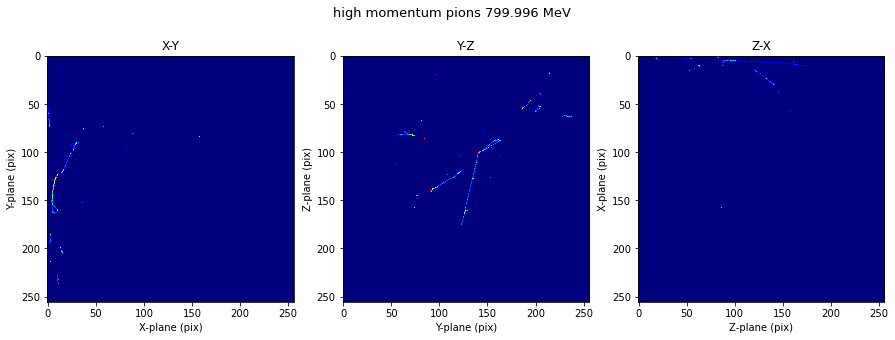

In [35]:
f = min(pion_data[:,1])
generate_img(pions[np.argmin(pion_data[:,1])],'low momentum pions %1.3f MeV'%f)
f = max(pion_data[:,1])
generate_img(pions[np.argmax(pion_data[:,1])],'high momentum pions %1.3f MeV'%f)

#### Low momentum pions, 105MeV, have more disordered tracks that are small but not concentrated. High momentum poins in the YZ plane are forked, and have fairly straight tracks with a few pixels coming off of each one.

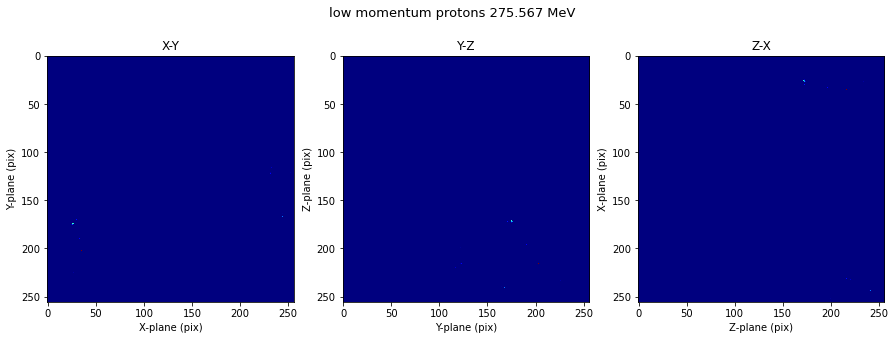

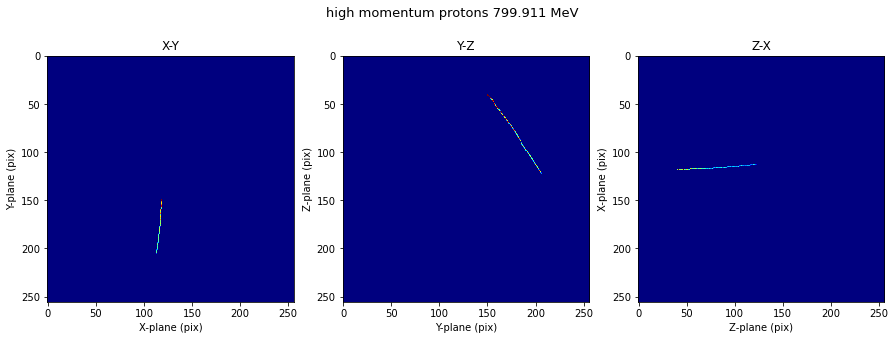

In [36]:
f = min(proton_data[:,1])
generate_img(protons[np.argmin(proton_data[:,1])],'low momentum protons %1.3f MeV'%f)
f = max(proton_data[:,1])
generate_img(protons[np.argmax(proton_data[:,1])],'high momentum protons %1.3f MeV'%f)

#### Low momentum protons have a much higher momentum than the other particles, due to their mass of 1Gev. Low momentum protons have a mass of 257MeV and have almost no track, smaller than that of the other particles. At their high momentum limit, 800MeV, they have straight tracks with no sprays. These straight tracks take up to 1/3 to 1/2 of the image width

#### Exploring the dataframe, we can get the mean total momentum of each particle. This ranges from 415 to 607 MeV for particles electrons, photons, muons, pions, protons. We can get momentum by getting the column['ptot'] from the dataframe, and get the mean. I get mean positions as well as individual momenta. 

In [29]:
#exploring truth data set
df.groupby('particle')['ptot'].mean().sort_values(ascending=False)

particle
2212.0    607.345648
211.0     453.905189
13.0      446.899438
22.0      421.728673
11.0      415.896163
Name: ptot, dtype: float64

In [30]:
#mean positions in x y and z are all similar for all particles
df.groupby('particle')['x'].mean().sort_values(ascending=False)

particle
22.0      62.172340
13.0      62.100279
11.0      61.995832
2212.0    61.616473
211.0     60.275179
Name: x, dtype: float64

In [31]:
df.groupby('particle')['y'].mean().sort_values(ascending=False)

particle
11.0      63.629541
2212.0    63.612814
13.0      63.497693
22.0      63.359626
211.0     63.314552
Name: y, dtype: float64

In [32]:
df.groupby('particle')['z'].mean().sort_values(ascending=False)

particle
211.0     63.963843
13.0      63.791155
2212.0    63.601386
22.0      63.595155
11.0      63.394110
Name: z, dtype: float64

#### We can see here that protons (particle ID 2212) have the greatest minimum momenta value, 275 MeV by a relatively large amount. I predict that this will make them easier to identify by the CNN if their energies are biased towards the high momenta values, which they will be, due to a high rest mass of 1GeV. I also predict that the particles (photons and electrons) with the same minimum momenta 35MeV, will be difficult to distinguish between one another. 

In [45]:
df.groupby('particle')['ptot'].min().sort_values(ascending=False)

particle
2212.0    275.567269
211.0     105.053489
13.0       90.020787
11.0       35.551400
22.0       35.046874
Name: ptot, dtype: float64

#### We can use groupby and describe to get the statistics of each particle type. Here we can see mean momenta for each particle, along with minimum and maxima momenta. This is interesting for analysis after we get the predicted labels as we can see why some particles are mislabeled as eachother, this may be due to their similar momenta. We can see that protons have the largest minimum momenta (and are the most massive) and we will see later that they are the most successfully predicted.

In [33]:
df.groupby('particle').describe()[['ptot']]

ptot                                                              \
            count        mean         std         min         25%         50%   
particle                                                                        
11.0      18000.0  415.896163  220.173474   35.551400  227.993935  411.211825   
13.0      18000.0  446.899438  204.924774   90.020787  269.723631  446.636628   
22.0      18000.0  421.728673  221.634581   35.046874  228.907961  424.234622   
211.0     18000.0  453.905189  199.719195  105.053489  280.423448  454.970960   
2212.0    18000.0  607.345648  115.764682  275.567269  514.779861  614.259671   

                                  
                 75%         max  
particle                          
11.0      607.863202  799.973662  
13.0      624.903554  799.912855  
22.0      615.213453  799.948612  
211.0     625.752867  799.996240  
2212.0    704.516187  799.911232

## Task1: Creating the convolutional neural network

### Theory
#### A neural network is a set of algorithms which has input layers, hidden layers, and an output layer. Each node represents a feature of the input problem. The output node calculates a score based on the inputs and the weights. In order to get the algorithm to 'learn', this score is predicted by an activation function. We choose an activation function that maps to our desired output. I use a convolutional neural network as I am trying to analyse images. For the convolutional layers, the activation function is ReLu, which is used for 'Regressing non-negative quantities (e.g energy)'. Here we have an image, with its pixel locations and values. These are positive quantities and so ReLu is the activation function chosen.

#### Max Pooling reduces the dimensionality of feature maps, and so a max pooling layer is needed after a convolutional layer. Max pooling takes the maximum values within a window which reduces say a 16 square feature map into four tiles, where the four are the maximum of their section. This essentially creates a condensed feature map. We compute the maximum value of the tiles within a window, and send this maximum into the corresponding tile of a condensed feature map

#### The output layer gives the predictions from the CNN. An output layer with softmax activation has N nodes for an N classification problem. Softmax produces a probability for the image being label 1,2,3,4,...N. 

### My CNN
#### For this project, I use a convolutional neural network, which is good at deriving information from images. Here we have 90000 sparse matrices, and so we only want to train on a small batch of these. So we use validation slice of 5000 to take the last 5000 images from the dense batch that is generated with the `nn_batch_generator` function. This function generates dense matrices from the sparse ones, as this is what is needed to be fed to the neural network. For my CNN I have an input layer that takes the shape of the image which is 256x256 pixels, in three dimensions, so it has the shape (256,256,3). The convolution layers apply a filter to the input which results in some activation. In this case I choose ReLu. Similar to that of the paper in the literature from **MicroBooNE** I start with two convolutional layers with the same number of nodes (16) and strides (2,2) and (1,1). When strides are 2, we move the filters to 2 pixels at a time. This significantly reduces the number of trainable parameters from 748,725 to 172,725, which helps to speed up the neural network. Next I have max pooling, which reduces the dimensionality of the problem. I then include two more convolution layers with a reduced number of nodes (8,8) along with another max pooling to further reduce dimensionality. I then include a drop out layer of 0.2 to reduce overfitting, dropout works by randomly setting the outgoing edges of neurons that make up the hidden layers to 0 at each update of training. 

#### Next, in order to send our image to the dense layer, we need to unravel it into a flat 1D layer. This is done using `Flatten`.This is then passed to the hidden layer with 50 nodes, we have quite a few nodes here as we want our CNN to be able to specify the particles from the given images. My CNN is used for object recognition, a hidden layer that is used to identify the track length cannot solely identify a particle, however when placed in conjunction with additional layers used to identify track color, shape, etc the neural network can then make predictions and identify the particles using this visual data. I then include another dropout layer of 0.2. This is because, when using just one drop out layer, the validation loss was increasing greatly, this meant that the CNN was overtraining after the first epoch, so I adressed this issue by adding another drop out layer.

#### Finally, this is passed to the output layer, which has 5 nodes and activation softmax, which is used for multiclass classification probability. This means the output of the predictions from the CNN produces an array of length 5, where the probability for each particle is in each corresponding position, for example, a prediction of [9E-1,4E-15,0,5E-3,8E-12] shows that the CNN identifies this particle as particle 0, which is an electron as it has the highest probability in position 0.

#### This is an attempt of a neural network that did not work as well:

`visible = Input(shape=256*256*3)`

`input_reshape = Reshape((256,256,3))(visible)`

`conv1 = Conv2D(9, kernel_size=(3,3),strides=(2, 2),activation='relu')(input_reshape)`


`conv2 = Conv2D(9, kernel_size=(3,3),strides=(1, 1),activation='relu')(conv1)`


`pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)`


`conv3= Conv2D(3, kernel_size=(3,3),strides=(1, 1),activation='relu')(pool1)`


`conv4= Conv2D(3, kernel_size=(3,3),strides=(1, 1),activation='relu')(conv3)`


`pool2 = MaxPooling2D(pool_size=(2, 2))(conv4)`


`flat = Flatten()(pool2)`


`hidden1 = Dense(50, activation='relu')(flat)`


`dropout1 = Dropout(.2, input_shape=(2,))(hidden1)`


`output = Dense(5, activation='softmax')(hidden1)`


`cnn1 = Model(inputs=visible, outputs=output)`


`cnn1.summary()`
`plot_model(cnn1, show_shapes=True)`



#### This model gave an increasing validation loss, and so when I used early stopping, it stopped after only one epoch. I have since tried a few models and the best predictions I obtain is from the following model:

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 196608)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 127, 127, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 8)         1160      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 58, 58, 8)         584   

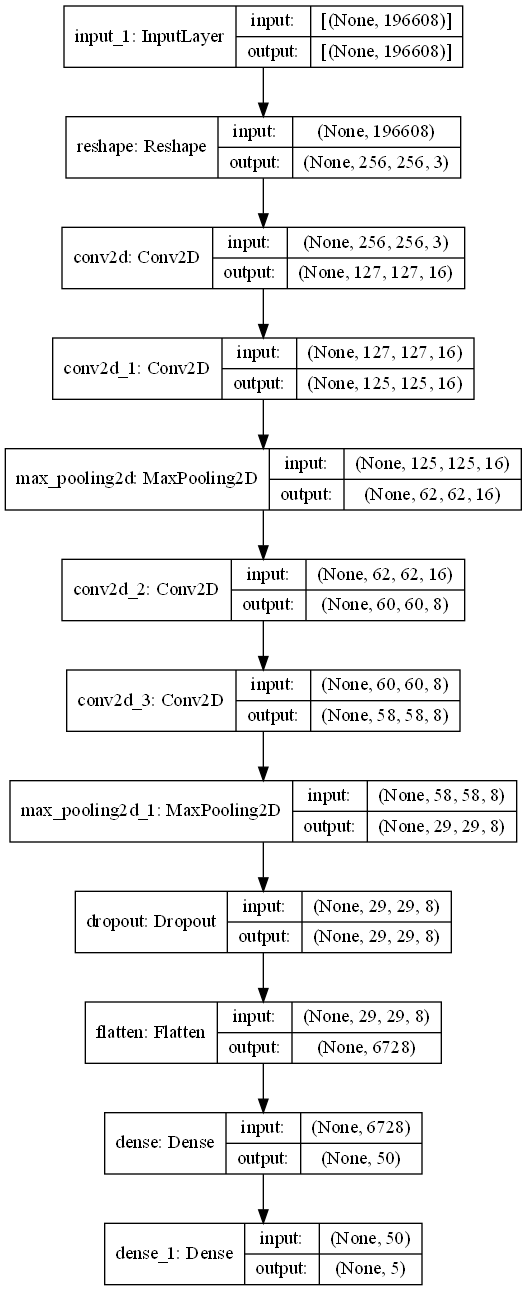

In [52]:
#this line gets rid of errors that were being thrown up
tf.compat.v1.experimental.output_all_intermediates(True)
#shape of the input layer should match the shape of the prepared images
visible = Input(shape=256*256*3)
input_reshape = Reshape((256,256,3))(visible)
#ReLU is the activation function of our convolution layer with 3x3 kernel and 2,2 strides
conv1 = Conv2D(16, kernel_size=(3,3),strides=(2, 2),activation='relu')(input_reshape)
#convolution layer with 16 nodes, relu, and 1,1 strides
conv2 = Conv2D(16, kernel_size=(3,3),strides=(1, 1),activation='relu')(conv1)

#pooling 2x2 layer to reduce dimensionality
pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
#convolution layer with 8 nodes and relu activation
conv3= Conv2D(8, kernel_size=(3,3),strides=(1, 1),activation='relu')(pool1)
#final convolution layer with 8 nodes and relu activation
conv4= Conv2D(8, kernel_size=(3,3),strides=(1, 1),activation='relu')(conv3)

#pooling 2x2 layer to further reduce dimensionality
pool2 = MaxPooling2D(pool_size=(2, 2))(conv4)
#dropout layer to reduce overfitting
dropout1 = Dropout(.2, input_shape=(2,))(pool2)

#flatten the image to send to hidden layer
flat = Flatten()(dropout1)
#hidden layer with 50 nodes to identify features
hidden1 = Dense(50, activation='relu')(flat)
#another dropout layer to reduce overfitting
dropout2 = Dropout(.2, input_shape=(2,))(hidden1)

#N=5 nodes for 5 particle classifications with softmax used as activation
output = Dense(5, activation='softmax')(hidden1) 
cnn1 = Model(inputs=visible, outputs=output)
#summarize layers
cnn1.summary()
plot_model(cnn1, show_shapes=True)

In [53]:
#this function modifies the particle labels in order for it to be passed to the CNN. Particle labels of [11,22,13,211,2212] are 
#changed to [0,1,2,3,4], so that the CNN and the output layer of the softmax function and 5 nodes can correctly identify
#the particles
def modifyValues(l):
    for i,x in enumerate(l):  
        if x == 11:
            l[i] = 0
        elif x == 22:
            l[i] = 1
        elif x == 13:
            l[i] = 2
        elif x == 211:
            l[i] = 3
        elif x == 2212:
            l[i] = 4
    return l
#the j array are the truth train labels (index 0) where the labels are now 0 to 4
j = modifyValues(truth_train[:,0])

#### The adam optimizer is essentially stochastic gradient descent for machine learning, but whilst classic stochastic gradient descent does not update its learning rate throughout training, the adam optimizer does. sparse categorical crossentropy is used as the loss as this is used when the classes are mutually exclusive (e.g. the electron can only be an electron, it cannot be labelled two things). Accuracy metrics are used so that I can see if the model is working, i.e. that accuracy goes up and validation loss goes down and does not plateau or go upward.

In [54]:
#compile the model using the adam optimizer and sparse categorical crossentropy loss, metrics=accuracy means we can 
#evaluate the loss over epochs and see the success of the model
cnn1.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

#### Here I run the model for a small set of the training dataset. This is because the sparse matrices need to be converted into dense matrices which takes a lot of computing power, thus we don't want to train on the whole data set, so we only train on 5000. I use reduce learning rate to stop overtraining. The learning rate looks at the validation loss, and controls how quickly the model is adapted to the problem. When the valiation loss starts to go up or plateau, the model should adjust to fix this, it has a patience of 1 so will trigger the learning rate update after 1 epoch, multiplying it by a factor of 0.2. The minimum learning rate is 0.01 and will stop when it reaches this. Smaller learning rates require more training epochs given the smaller changes made to the weights each update, whereas larger learning rates result in rapid changes and require fewer training epochs.

#### The early stopping callback in keras allows you to specify the performance measure to monitor, the trigger, and once triggered, it will stop the training process, again we measure val_loss, which we want to minimize, which will stop after 1 epoch of no change.

In [55]:
#validation slice of 5000 means we are training on a small batch of 5000 images and truth arrays
validation_slice=5000
#batch size of 32
batch_size=32
#reduce learning rate to prevent overfitting: keep updating the model
ReduceLR = ReduceLROnPlateau(monitor="val_loss",factor=0.2,patience=1,min_lr=0.01)
#early stopping stops running the model if it is not working to save time
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.0, patience=1, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False)
#fit cnn using call backs and a batch of x train samples
history_cnn = cnn1.fit(nn_batch_generator(x_train[:-validation_slice],j[:-validation_slice],batch_size=batch_size),epochs=10,steps_per_epoch=int((50000-validation_slice)/batch_size),
                      validation_data=(x_train[-validation_slice:],j[-validation_slice:]),callbacks=[ReduceLR,early_stopping])

Epoch 1/10
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 32.0000 - loss: 1.0418 - accuracy: 0.5215

C:\Users\betc\anaconda3\envs\daml\lib\site-packages\tensorflow\python\keras\engine\training.py:2458: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1406/1406 [==============================] - 563s 399ms/step - batch: 702.5000 - size: 32.0000 - loss: 1.0418 - accuracy: 0.5215 - val_loss: 0.7557 - val_accuracy: 0.6302 - lr: 0.0010
Epoch 2/10
1406/1406 [==============================] - 585s 417ms/step - batch: 702.5000 - size: 31.9829 - loss: 0.7225 - accuracy: 0.6483 - val_loss: 0.7216 - val_accuracy: 0.6394 - lr: 0.0010
Epoch 3/10
1406/1406 [==============================] - 496s 353ms/step - batch: 702.5000 - size: 31.9829 - loss: 0.6493 - accuracy: 0.6713 - val_loss: 0.7514 - val_accuracy: 0.6406 - lr: 0.0010


#### Here I plot loss and validation loss. The ideal model would have loss and val loss on top of each other, without val loss plateauing. If they are not, the model seems to be overtrained. I have done many runs with many different parameters of my model, and often has resulted in validation loss going upward. Hence I include both reduce learning rate and early stopping to prevent my model from over training. This new result with convolutional layers of (16,16,8,8), two dropout layers of (0.2), gives the best result, despite only running for three epochs. Whilst this is a very small amount of epochs to run for, it is the best validation loss I have achieved with my model, and is prevented from running more epochs due to the constraints I have introduced.


- More convolution nodes led to an increase in overfitting

- less dropout layers led to an increase in overfitting

- A stricter early stopping led to only one epoch being run

#### At the moment, the val_loss is still very high. Ideally, the model would run for many more epochs subsequently reducing validation loss as it trains. However the parameters for this to work have not yet been found, and can be found by doing a hyperparameter search.

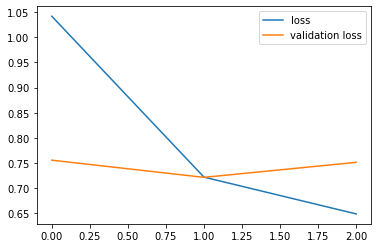

In [56]:
#get loss and val loss from the history of the fitted model
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']
#plot loss and val loss against the number of epochs
plt.plot(loss,label='loss')
plt.plot(val_loss,label='validation loss')
plt.legend()

In [101]:
#save model
cnn1.save('CNN.h5')

In [58]:
#the k array are the truth TEST labels (index 0) where the labels are now 0 to 4 instead of 11,22,.. etc
k = modifyValues(truth_test[:,0])

In [59]:
#evaluate the model on a subset (5000) of the test data set and test labels, for a batch size of 50
cnn1.evaluate(nn_batch_generator(x_test[-5000:], k[-5000:],batch_size=50),steps=5000/50)

[0.7570009112358094, 0.638]

In [60]:
#get the metrics names so we can see what corresponds to the values printed by cnn.evaluate.
cnn1.metrics_names

['loss', 'accuracy']

In [61]:
#get the predictions of the x test data set and their particle labels
predictions1 = cnn1.predict(nn_batch_generator(x_test[-5000:],k[-5000:],batch_size=50),steps=5000/50)

In [62]:
#print predictions to see its format. As we can see, it prints an array of 5 probabilities. The highest probability is the 
#prediction of the particle. E.g. if the index of the maximum value (argmax) is at 1, this is the predicted particle label,
#a photon
predictions1

array([[7.6844211e-09, 7.0282481e-06, 6.3396606e-06, 1.7516224e-02,
        9.8247033e-01],
       [5.7449383e-01, 4.2517859e-01, 1.5731395e-08, 3.2767479e-04,
        1.2701965e-12],
       [5.7917833e-02, 5.3801160e-02, 4.1873303e-01, 4.6490145e-01,
        4.6465276e-03],
       ...,
       [4.7060066e-01, 4.7482210e-01, 9.1989161e-03, 4.3960020e-02,
        1.4182052e-03],
       [5.1962111e-06, 2.0045305e-03, 1.3562891e-03, 9.5732175e-03,
        9.8706079e-01],
       [8.7472431e-02, 6.6287816e-02, 3.2224047e-01, 5.1449674e-01,
        9.5024975e-03]], dtype=float32)

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns

In [65]:
labels = [0,1,2,3,4]
particle_labels = ['electron','photon','muon','pion','proton']
#getting the maximum arguments from the prediction arrays
max_i = np.argmax(predictions1,axis=1)
#generating a confusion matrix for the given true labels and the predicted labels
cf_matrix = confusion_matrix(k[-5000:],max_i, labels=None, sample_weight=None, normalize='true')

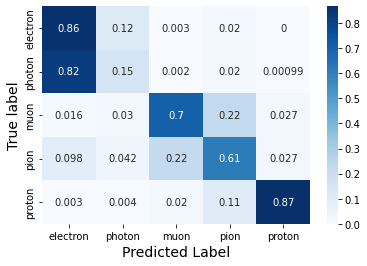

In [66]:
#plotting the confusion matrix to see which particles the CNN had difficulty distinguishing between
sns.heatmap(cf_matrix, annot=True, cmap='Blues',xticklabels=particle_labels, yticklabels=particle_labels)
plt.xlabel("Predicted Label",fontsize=14)
plt.ylabel("True label",fontsize=14)
plt.show()

#### Here the confusion matrix gives a good visual interpretation of how well the CNN did. We can see that it predicted protons well, with 87% of protons being identified as protons, it predicted electrons well correctly identifying 86%, and muons relatively well with 70% of these identified correctly. Pions were ok, with 61% being identified correctly. The problems we run into are photons: 82% were identified as electrons, and 12% of electrons being identified as photons. This means that only 15% of photons were identified correctly, which means my CNN does not work for photon classification. This means that there are similarities between electron and photon tracks. We can see this by printing some electron and photon tracks with their corresponding mean momenta here. We see they both have quite a messy track with lots of sprays. Since they look similar and the CNN looks at characteristics of the pixels, it is clear to see here why they may have been mistaken for eachother:


In [67]:
#### We can also see that the mean of electron and photon momenta are quite similar
#we can print images of the particles with mean momenta.
df.groupby('particle')['ptot'].mean().sort_values()

particle
11.0      415.896163
22.0      421.728673
13.0      446.899438
211.0     453.905189
2212.0    607.345648
Name: ptot, dtype: float64

In [68]:
#we can get the indexes where the electron momentum is close to the mean by indexing, using the means generated above:
np.where(np.isclose(electron_data[:,1],415.8,atol=0.05))[0][0]

8390

In [69]:
#we can get the indexes where the photon momentum is close to the mean by indexing, using the photon momenta mean above:
np.where(np.isclose(photon_data[:,1],421.7,atol=0.05))[0][0]

17394

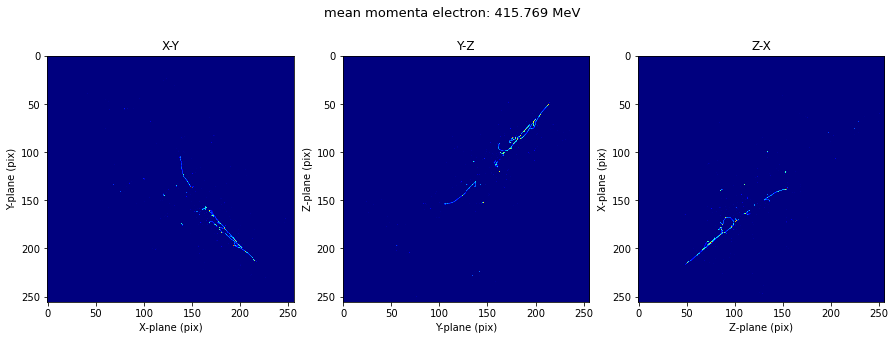

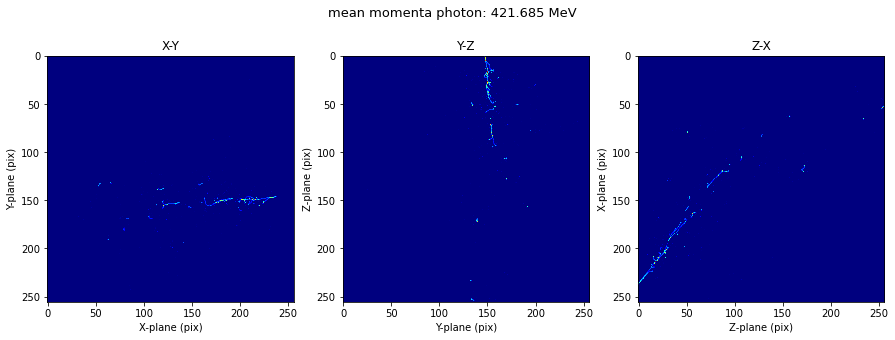

In [70]:
#get the value of the mean momenta of the electron we will be plotting by indexing where momentum is close to the mean value
#given above
f = electron_data[:,1][np.where(np.isclose(electron_data[:,1],415.8,atol=0.05))[0][0]]
#generate the image
generate_img(electrons[np.where(np.isclose(electron_data[:,1],415.8,atol=0.05))[0][0]],'mean momenta electron: %1.3f MeV'%f)
#get the value of the mean momenta of the photon we will be plotting
f = photon_data[:,1][np.where(np.isclose(photon_data[:,1],421.7,atol=0.05))[0][0]]
#generate the image
generate_img(photons[np.where(np.isclose(photon_data[:,1],421.7,atol=0.05))[0][0]],'mean momenta photon: %1.3f MeV'%f)

#### This cell generates mean momenta electron image and mean momenta photon image. We can see quite clearly that the two tracks are very similar. Physically, this is because photons themselves are invisible, but produce electron-position pairs, so as they interact, the tracks left over look very similar to that of electrons. Both tracks have many sprays and cover around half the width. This explains why the CNN has trouble distinguishing the photons from electrons. In practice, the two tracks are almost indistinguishable, due to their similar tracks. 

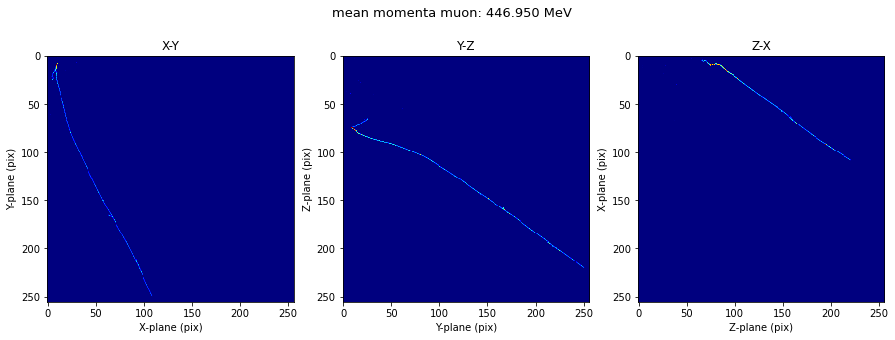

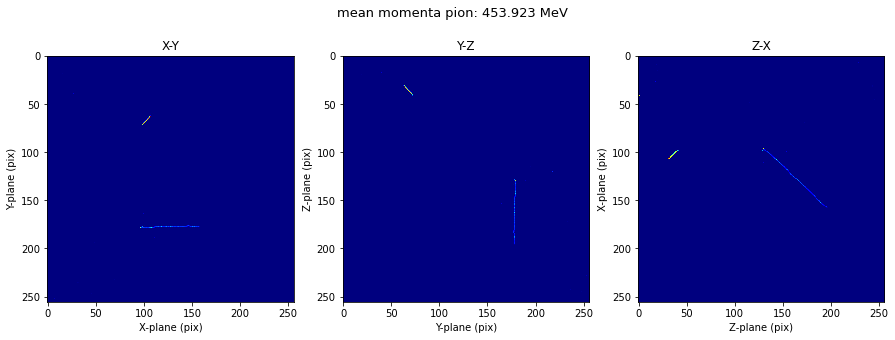

In [71]:
#get the value of the mean momenta of the muon we will be plotting
f = muon_data[:,1][np.where(np.isclose(muon_data[:,1],446.9,atol=0.05))[0][0]]
#generate image
generate_img(muons[np.where(np.isclose(muon_data[:,1],446.9,atol=0.05))[0][0]],'mean momenta muon: %1.3f MeV'%f)
#get the value of the mean momenta of the pion we will be plotting
f = pion_data[:,1][np.where(np.isclose(pion_data[:,1],453.9,atol=0.05))[0][0]]
#generate image
generate_img(pions[np.where(np.isclose(pion_data[:,1],453.9,atol=0.05))[0][0]],'mean momenta pion: %1.3f MeV'%f)

#### There are also some similarites between muon and pion tracks, as 22% of muons were mistakenly identified as pions, and 22% of pions identified as muons. We can also print the particle tracks of mean pion and muons to see any similarities. A muon has a mass of 105.6Mev, and a pion has a mass of 139.5MeV, these are not too far apart from eachother in comparison to the other particles, which is 0.5MeV for an electron, 0 for a photon, and 1GeV for a proton. This similar mass results in similar momenta which may be responsible for relatively similar tracks. Low momenta muons are mistaken for pions as when they are of low energy, they have very short straight tracks, which can be easily interpreted as a pion. As we can see, both pions and muons have straight tracks, but pions have two features, a very short track and then  a straight line about 75 pixels long. Muons only have one straight line, which is much longer. The characteristics of the line may have caused the CNN to not be able to distinguish between them perfectly, hence a confusion between the two of 22%, however the two have features that keep them seperate from eachother, the length of the tracks and the number of tracks. We know that the CNN mostly predicts them correctly, which may be due to these different features, with the misclassfications occuring at low momenta.

---

#### From the CNN predictions, I get those that were successfully predicted, and those that were unsuccessfully predicted, in order to try to find a trend as to why.

In [73]:
#initialize empty arrays
correct_guess_pos = []
incorrect_guess_pos = []
#get the last 5000 labels in k
K = k[-5000:]
#loop over the predictions, if the prediction corresponds to the true label, append to a correct list
for i in range(len(predictions1)):
    if np.argmax(predictions1[i]) == K[i]:
        correct_guess_pos.append(i)
    #if the prediction does not correspond to the true label, append to an incorrect list
    else:
        incorrect_guess_pos.append(i)

In [74]:
#get a subset of the truth data set that again is the last 5000 values
truth_test_batch = truth_test[-5000:]

In [75]:
correct_vals = []
incorrect_vals = []
#for the correct values, get the truth data
for index in correct_guess_pos:
    correct_vals.append(truth_test_batch[index])
#for the incorrect values, get the truth data
for index in incorrect_guess_pos:
    incorrect_vals.append(truth_test_batch[index])

In [76]:
#checking code works and these values add up to 5000
len(correct_vals),len(incorrect_vals)

(3190, 1810)

In [77]:
#generate a correct data frame
correct_pred = pd.DataFrame(data=correct_vals, columns=['particle', 'ptot', 'px', 'py', 'pz', 'x', 'y', 'z'])
#generate an incorrect data frame
incorrect_pred = pd.DataFrame(data=incorrect_vals, columns=['particle', 'ptot', 'px', 'py', 'pz', 'x', 'y', 'z'])

In [80]:
#group the data frames by their particle name 
incorrect_pred.groupby('particle')
correct_pred.groupby('particle')

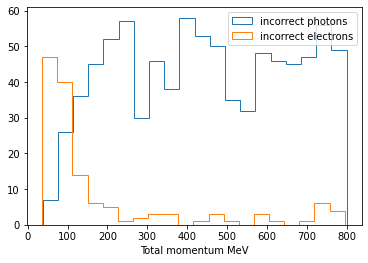

In [113]:
#get the total momentum arrays for each particle incorrectly predicted by the CNN, do this by locating where the particle label
#equals each particle id, and get the ptot column by ['ptot']
inc_ptot_e = np.array(incorrect_pred.loc[incorrect_pred['particle'] == 0.0]['ptot'])
inc_ptot_phot = np.array(incorrect_pred.loc[incorrect_pred['particle'] == 1.0]['ptot'])
inc_ptot_mu = np.array(incorrect_pred.loc[incorrect_pred['particle'] == 2.0]['ptot'])
inc_ptot_pi = np.array(incorrect_pred.loc[incorrect_pred['particle'] == 3.0]['ptot'])
inc_ptot_pro = np.array(incorrect_pred.loc[incorrect_pred['particle'] == 4.0]['ptot'])

#plot a histogram to find a trend in data of incorrectly predicted photons and electrons
plt.hist(inc_ptot_phot,label='incorrect photons',histtype=u'step',bins=20)
plt.hist(inc_ptot_e,label='incorrect electrons',histtype=u'step',bins=20)
plt.xlabel('Total momentum MeV')
plt.legend()
plt.show()

In [82]:
#get the total momentum arrays for each particle correctly predicted by the CNN, do this by locating where the particle label
#equals each particle id, and get the ptot column by ['ptot']
ptot_e = np.array(correct_pred.loc[correct_pred['particle'] == 0.0]['ptot'])
ptot_phot = np.array(correct_pred.loc[correct_pred['particle'] == 1.0]['ptot'])
ptot_mu = np.array(correct_pred.loc[correct_pred['particle'] == 2.0]['ptot'])
ptot_pi = np.array(correct_pred.loc[correct_pred['particle'] == 3.0]['ptot'])
ptot_pro = np.array(correct_pred.loc[correct_pred['particle'] == 4.0]['ptot'])

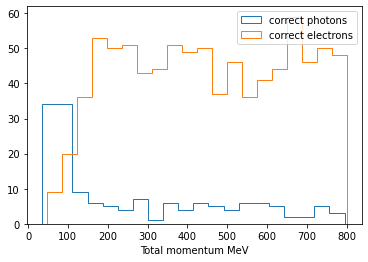

In [112]:
#plot a histogram to find a trend in data of correctly predicted photons and electrons
plt.hist(ptot_phot,label='correct photons',histtype=u'step',bins=20)
plt.hist(ptot_e,label='correct electrons',histtype=u'step',bins=20)
plt.xlabel('Total momentum MeV')
plt.legend()
plt.show()

#### These histograms tell us something interesting about the error in the prediction of the electrons and photons. The correctly predicted electrons span a range of momenta from around 50 to 800MeV. However the incorrectly predicted electrons are all in the low momenta region up to 200MeV. Conversely, the incorrect photons spanned all energies whilst the correct photons were at low energies. So at low energies, the CNN could correctly identify photons, but could not distinguish between photons and electrons for higher energies. The CNN could mostly predict electrons correctly as electrons and so the correct electrons momenta covers the whole range. The incorrect electrons are only a small subset at the low energy regions. This tells us that electrons were mostly predicted correctly as electrons, whereas photons were mostly mislabeled, except for in the low energy region.

#### An arbitrary test to do on the data is in the cell below, I print the length of correctly and incorrectly predicted protons. Protons are predicted well, the amount of correctly predicted photons (858) is much greater than incorrectly corrected photons (132), as confirmed by the confusion matrix (87% predicted correctly). This is because they are mainly in the high momentum region due to their large mass and characteristic straight tracks.

In [109]:
len(ptot_pro),len(inc_ptot_pro) 

(858, 132)

#### We can also explain why muons and pions are mistaken for eachother but not for protons: the protons are in mostly in the high energy region, due to their high rest mass of 1GeV, and so are are easy to distinguish by the CNN. This is why, despite having straight tracks the same as the muons and pions, they are not mistaken for them, as they are not in the low momenta region. It is in the low momenta region where pions and muons are mistaken for eachother. As we can see total momentum of the photons ranges from ~300MeV to 800MeV. As predicted, the incorrectly predicted muons were at low energies, where they look like pions. They are not mistaken for protons as protons are in the high energy region.

In [35]:
proton_momenta = np.array(df[df['particle']==2212.0]['ptot'])

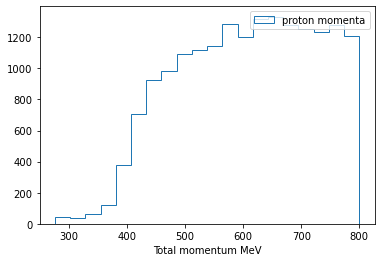

In [36]:
#plot a histogram to find a trend in data of momentum range for all protons
plt.hist(proton_momenta,label='proton momenta',histtype=u'step',bins=20)
plt.xlabel('Total momentum MeV')
plt.legend()
plt.show()

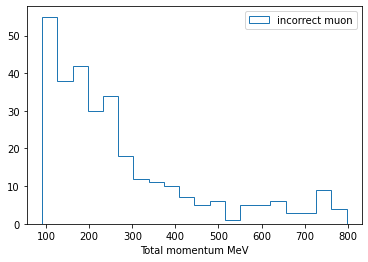

In [154]:
plt.hist(inc_ptot_mu,label='incorrect muon',histtype=u'step',bins=20)
plt.xlabel('Total momentum MeV')
plt.legend()
plt.show()

--- 

## Hyperparameter search

'Explore different architectures for the model, and explain in detail your choice of model, and the final parameters chosen. Consider doing a robust hyperparameter search.'

In [37]:
from sklearn.model_selection import ParameterGrid

#### In order to find the optimal model, the optimal parameters need to be found. These are the number of nodes in the convolution layers, the number of nodes in the dense layers, and the drop out percentage. Here the convolutional layers take similar values to the ones I have implemented, with some changed. Dense layers takes 20 or 50, and dropout can be either 0.1 or 0.2.

In [38]:
hyperparams = {'conv_layers': [[16, 12, 8, 4], [16, 16, 8, 8], [9,9,3,3]], 'dense_layers': [[20], [40], [50]], 'dropout': [0.1, 0.2]}

In [39]:
#view list of combinations of hyperparameters
list(ParameterGrid(hyperparams))

[{'conv_layers': [16, 12, 8, 4], 'dense_layers': [20], 'dropout': 0.1},
 {'conv_layers': [16, 12, 8, 4], 'dense_layers': [20], 'dropout': 0.2},
 {'conv_layers': [16, 12, 8, 4], 'dense_layers': [40], 'dropout': 0.1},
 {'conv_layers': [16, 12, 8, 4], 'dense_layers': [40], 'dropout': 0.2},
 {'conv_layers': [16, 12, 8, 4], 'dense_layers': [50], 'dropout': 0.1},
 {'conv_layers': [16, 12, 8, 4], 'dense_layers': [50], 'dropout': 0.2},
 {'conv_layers': [16, 16, 8, 8], 'dense_layers': [20], 'dropout': 0.1},
 {'conv_layers': [16, 16, 8, 8], 'dense_layers': [20], 'dropout': 0.2},
 {'conv_layers': [16, 16, 8, 8], 'dense_layers': [40], 'dropout': 0.1},
 {'conv_layers': [16, 16, 8, 8], 'dense_layers': [40], 'dropout': 0.2},
 {'conv_layers': [16, 16, 8, 8], 'dense_layers': [50], 'dropout': 0.1},
 {'conv_layers': [16, 16, 8, 8], 'dense_layers': [50], 'dropout': 0.2},
 {'conv_layers': [9, 9, 3, 3], 'dense_layers': [20], 'dropout': 0.1},
 {'conv_layers': [9, 9, 3, 3], 'dense_layers': [20], 'dropout': 0.

#### Psuedo code
`loss = []`
`val_loss = []`


`for i in range(number of parameter combinations):`

    model = Model(parameters[i])
    history = model.fit()
    loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])
    
    return loss, val_loss

In [40]:
#create function that creates a CNN model, taking in parameters of layers and dropout
def build_cnn(activation = 'relu',
              dropout_rate = dropout,
              optimizer = 'Adam', nodes=hyperparams1['conv_layers'],dense=hyperparams1['dense_layers']):
    tf.compat.v1.experimental.output_all_intermediates(True)
    visible = Input(shape=256*256*3)
    input_reshape = Reshape((256,256,3))(visible)
    #ReLU is the activation function of our convolution layer with 3x3 kernel and 2,2 strides
    conv1 = Conv2D(nodes[0], kernel_size=(3,3),strides=(2, 2),activation='relu')(input_reshape)
    #convolution layer with X nodes, relu, and 1,1 strides
    conv2 = Conv2D(nodes[1], kernel_size=(3,3),strides=(1, 1),activation='relu')(conv1)

    #pooling 2x2 layer to reduce dimensionality
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
    #convolution layer with X nodes and relu activation
    conv3= Conv2D(nodes[2], kernel_size=(3,3),strides=(1, 1),activation='relu')(pool1)
    #final convolution layer with X nodes and relu activation
    conv4= Conv2D(nodes[3], kernel_size=(3,3),strides=(1, 1),activation='relu')(conv3)

    #pooling 2x2 layer to further reduce dimensionality
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv4)
    #dropout layer to reduce overfitting
    dropout1 = Dropout(dropout_rate, input_shape=(2,))(pool2)

    #flatten the image to send to hidden layer
    flat = Flatten()(dropout1)
    #hidden layer with X nodes to identify features
    hidden1 = Dense(dense[0], activation='relu')(flat)
    #another dropout layer to reduce overfitting
    dropout2 = Dropout(dropout_rate, input_shape=(2,))(hidden1)

    #N=5 nodes for 5 particle classifications with softmax used as activation
    output = Dense(5, activation='softmax')(hidden1) 
    model = Model(inputs=visible, outputs=output)
    
    #compile and return the model
    model.compile(
        loss='sparse_categorical_crossentropy', 
        optimizer=optimizer, 
        metrics=['accuracy']
    )
    
    return model

In [41]:
def find_popt():
    loss_list = []
    val_loss_list = []
    #loop over the parameter combinations
    for i in range(len(list(ParameterGrid(hyperparams1)))):
        param = list(ParameterGrid(hyperparams1))[i]
        nodes = param['conv_layers']
        dense = param['dense_layers']
        dropout = param['dropout']
        #get model from build_cnn function that takes in the parameters
        model = build_cnn2(activation = 'relu',
                  dropout_rate = dropout,
                  optimizer = 'Adam', nodes=nodes,dense=dense)
        #fit the model with given parameters
        validation_slice = 5000
        batch_size = 32
        history_cnn = model.fit(nn_batch_generator(x_train[:-validation_slice],j[:-validation_slice],batch_size=batch_size),epochs=10,steps_per_epoch=int((50000-validation_slice)/batch_size),
                          validation_data=(x_train[-validation_slice:],j[-validation_slice:]),callbacks=[ReduceLR,early_stopping])
        #get loss by from history of model
        loss_list.append(history_cnn.history['loss'])
        val_loss_list.append(history_cnn.history['val_loss'])
        return loss_list, val_loss_list

#### This function returns the a list of loss and validation loss for each set of parameters. We can then index these lists and plot each loss and validation loss array for a given set of parameters.

#### I do not run this code as it takes up too much memory however this is how I would find the optimal parameters: by printing the loss curves for each parameter combination and finding the best one:

In [ ]:
loss_list,val_loss_list = find_popt2()
plt.plot(loss_list[0],val_loss_list[0],label=str(parameters[0]))
plt.plot(loss_list[1],val_loss_list[1],label=str(parameters[1])) #etc
plt.legend()
plt.show()

---

# Task 2

'Create an autoencoder (AE) to reduce noise in the detector images. Do injection tests of random noise with different intensities to check your results. Some code to generate noise can be found in the Keras AE tutorial'

In [60]:
from scipy import sparse

In [285]:
x_train, x_test, truth_train, truth_test = train_test_split(images,truth,train_size=50000,random_state=11)

#### To generate noise: we just apply a gaussian noise matrix and clip the images between 0 and 1. I am going to generate noise just for 500 particles and pass them through the autoencoder to resolve these back into their original images with the reduction of noise.



In [294]:
#normalize the train and test images so that they are between 0 and 1 - they need to be in this format so noise can be added and
#so that the sigmoid and binary cross entropy functions can work
max_val = max(x_test.max(), x_train.max())
x_train1 = x_train/255
x_test1 = x_train/255

In [295]:
#generating noise for 500 images by adding some fraction * a random gaussian distribution of noise
noise_factor = 0.3
x_train_noisy = x_train1[-500:] + noise_factor * np.random.normal(loc=0.0, scale=.5, size=x_train1[-500:].shape) 
x_test_noisy = x_test1[-500:] + noise_factor * np.random.normal(loc=0.0, scale=.5, size=x_test1[-500:].shape) 

In [296]:
#clipping the values so that they are between 0 and 1 with noise
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [297]:
#initialization of the sparse matrices of the noisy data
x_train_noisy = sparse.csr_matrix(x_train_noisy)
x_test_noisy = sparse.csr_matrix(x_test_noisy)

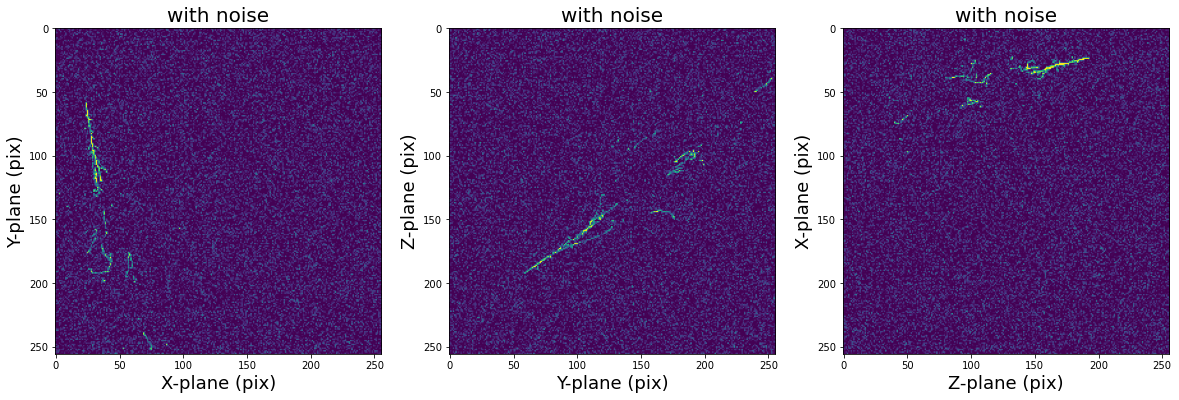

In [298]:
#plotting the normal data
labels=["X-Y","Y-Z","Z-X"]
fig = plt.figure(figsize=(20,6))
for i in range(3):

    plt.subplot(1,3,i+1)
    #Show the image with imshow:
    plt.imshow(toimage(x_train_noisy[0])[i])
    plt.xlabel('{}-plane (pix)'.format(labels[i].split("-")[0]),fontsize=18)
    plt.ylabel('{}-plane (pix)'.format(labels[i].split("-")[1]),fontsize=18)
    plt.title('with noise',fontsize=20)

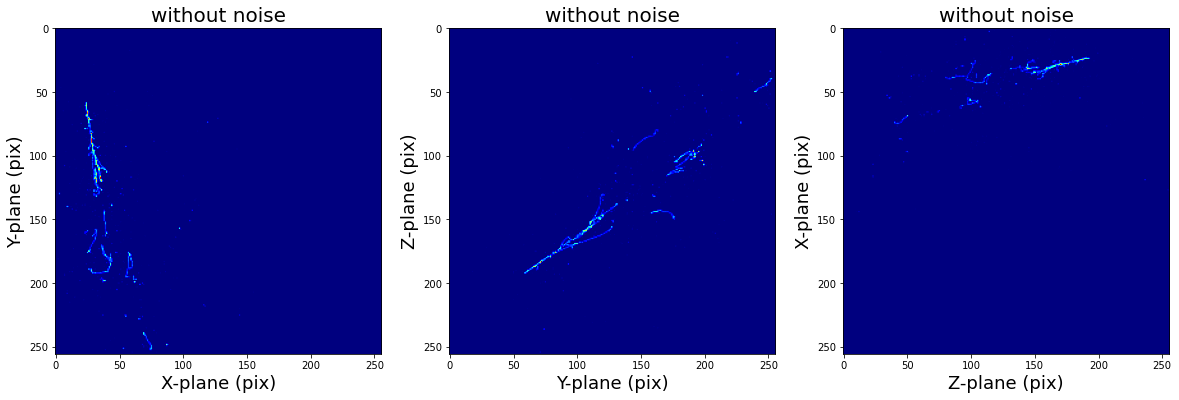

In [299]:
#plotting the noisy data
labels=["X-Y","Y-Z","Z-X"]
fig = plt.figure(figsize=(20,6))
for i in range(3):

    plt.subplot(1,3,i+1)
    #Show the image with imshow:
    plt.imshow(toimage(x_train[-500])[i],cmap='jet')
    plt.xlabel('{}-plane (pix)'.format(labels[i].split("-")[0]),fontsize=18)
    plt.ylabel('{}-plane (pix)'.format(labels[i].split("-")[1]),fontsize=18)
    plt.title('without noise',fontsize=20)


### Making an AE
#### Here I make an autoencoder which takes an input of 256 * 256 * 3 and outputs a flatten layer of the same shape. It is a convolutional autoencoder as we are dealing with images. Ideally, I would train the cae on a larger batch of dense matrices, however I quickly run into error problems. So here, I pass the training data and the noisy data to the model as arrays.


#### Binary cross entropy is used as the loss function as the AE wants to identify noise, thus they want to compare the noisy data and clean data. cross-entropy is the default loss function to use for binary classification problems, as it has target values 1 and 0. Output is a sigmoid activation function such that it ends up with the same shape as the original image, with pixel intensities in the range  [0,1].

In [300]:
#make visible layer the same shape as training set images
visible = Input(shape=(256*256*3))
input_reshape = Reshape((256,256,3))(visible)
#convoluting layers 16-8-4-2-1 with 3x3 kernels
enc_conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_reshape)
#two 2x2 pooling layers
enc_pool1 = MaxPooling2D((2, 2), padding='same')(enc_conv1)
enc_conv2 = Conv2D(8, (3, 3), activation='relu', padding='same')(enc_pool1)
#two 2x2 pooling layers
enc_pool2 = MaxPooling2D((2, 2), padding='same')(enc_conv2)
enc_conv3 = Conv2D(4, (3, 3), activation='relu', padding='same')(enc_pool2)
enc_conv4 = Conv2D(2, (3, 3), activation='relu', padding='same')(enc_conv3)
#output has a sigmoid activation (0,1)
enc_output = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(enc_conv4)
#flatten output
latent = Flatten()(enc_output)

In [301]:
encoder = Model(inputs=visible, outputs=latent)

In [302]:
#get shape of encoder
decoder_input = Input(shape=encoder.layers[-1].output_shape[1])
output_shape = encoder.layers[-2].output_shape[1:]
#reshape input of decoder to second to last layer
x = Reshape(output_shape)(decoder_input)
#give same structure as encoder (but reverse) with upsampling 2x2 layers and relu convoluted layers
dec_conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
dec_upsample1 = UpSampling2D((2, 2))(dec_conv1)
dec_conv2 = Conv2D(8, (3, 3), activation='relu', padding='same')(dec_upsample1)
dec_upsample2 = UpSampling2D((2, 2))(dec_conv2)
dec_conv3 = Conv2D(4, (3, 3), activation='relu', padding='same')(dec_upsample2)
dec_conv4 = Conv2D(2, (3, 3), activation='relu', padding='same')(dec_conv3)
#give output layer sigmoid (0,1) activation function
dec_output = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(dec_conv4)
output_flat = Flatten()(dec_output)

In [303]:
#create decoder
decoder = Model(inputs=decoder_input, outputs=output_flat)

In [304]:
#generate convolutional autoencoder
i   = encoder.input
cae = Model(i, decoder(encoder(i)), name='ConvAE')
cae.summary()

Model: "ConvAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 196608)]          0         
_________________________________________________________________
model_2 (Functional)         (None, 4096)              1993      
_________________________________________________________________
model_3 (Functional)         (None, 196608)            1743      
Total params: 3,736
Trainable params: 3,736
Non-trainable params: 0
_________________________________________________________________


In [307]:
#compile the model. Here we use binary cross entropy as the output is sigmoid
cae.compile(optimizer='adam', loss='binary_crossentropy')

In [308]:
#fit the data comparing x train noise with x train, saving 100 samples for validation
cae_history = cae.fit(x_train_noisy[-400:],x_train1[-400:],epochs=10,batch_size=32,
                      validation_data=(x_train1[-500:-400],x_train1[-500:-400]))

Train on 400 samples, validate on 100 samples
Epoch 1/10
400/400 [==============================] - 23s 58ms/sample - loss: 0.6673 - val_loss: 0.6156
Epoch 2/10
400/400 [==============================] - 25s 62ms/sample - loss: 0.5354 - val_loss: 0.4489
Epoch 3/10
400/400 [==============================] - 26s 65ms/sample - loss: 0.4092 - val_loss: 0.3476
Epoch 4/10
400/400 [==============================] - 28s 69ms/sample - loss: 0.2999 - val_loss: 0.2388
Epoch 5/10
400/400 [==============================] - 26s 66ms/sample - loss: 0.1781 - val_loss: 0.0929
Epoch 6/10
400/400 [==============================] - 26s 65ms/sample - loss: 0.0470 - val_loss: 0.0245
Epoch 7/10
400/400 [==============================] - 27s 67ms/sample - loss: 0.0225 - val_loss: 0.0237
Epoch 8/10
400/400 [==============================] - 26s 65ms/sample - loss: 0.0225 - val_loss: 0.0238
Epoch 9/10
400/400 [==============================] - 27s 66ms/sample - loss: 0.0224 - val_loss: 0.0236
Epoch 10/10
400/40

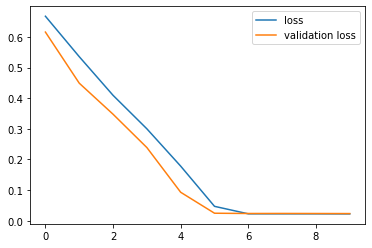

In [312]:
#plot loss and validation loss for the convolutional autoencoder
loss = cae_history.history['loss']
val_loss = cae_history.history['val_loss']
plt.plot(loss,label='loss')
plt.plot(val_loss,label='validation loss')
plt.legend()

In [315]:
prediction_ae = cae.predict(x_test_noisy)

#### Here, the AE is meant to give an image of the clear x tests, with the noise extracted, however I get a blank image. When printing the predictions as below, we can see it is no longer a sparse object, with each value non-zero. This is probably due to an error in the normalization of the image or the architecture of the AE. I print the actual x test noisy image to see the detail that the autoencoder isn't giving. Given more time, I would go over the normalization of my images, try out more architectures and train for a much larger dataset.

In [316]:
prediction_ae[50]

array([0.04711524, 0.00726452, 0.48668844, ..., 0.41235816, 0.01920909,
       0.5841625 ], dtype=float32)

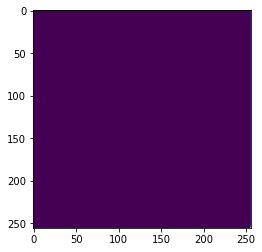

In [314]:
plt.imshow((prediction_ae[50]).reshape(256,256,3)[:,:,0])
plt.show()

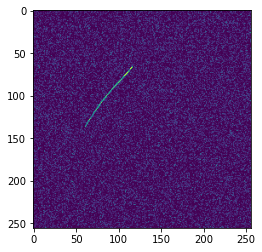

In [305]:
#the actual x_test with noise
plt.imshow(toimage(x_test_noisy[50])[0])

In [317]:
#a function that generates sparse matrices for some input of fractional noise:
def noise(noise_factor):
    x_train_noisy = x_train[-500:] + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train[-500:].shape) 
    x_test_noisy = x_test[-500:] + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test[-500:].shape)
    #normalizing the values so they are between 0 and 1
    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    x_test_noisy = np.clip(x_test_noisy, 0., 1.)
    return x_train_noisy, x_test_noisy

---